In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from IPython.display import clear_output
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning) 

from utils.constants import ARTIFACTS_DIR

device = "cuda" if torch.cuda.is_available() else "cpu"

DS_NAME = "gaussians"
RUN_DIR = os.path.join(ARTIFACTS_DIR, "toy", DS_NAME)
UNCONDITIONAL_DIR = os.path.join(RUN_DIR, "unconditional")
CONDITIONAL_DIR = os.path.join(RUN_DIR, "conditional")
CLASSIFIER_DIR = os.path.join(RUN_DIR, "classifier")

os.makedirs(UNCONDITIONAL_DIR, exist_ok=True)
os.makedirs(CONDITIONAL_DIR, exist_ok=True)
os.makedirs(CLASSIFIER_DIR, exist_ok=True)

## Dataset

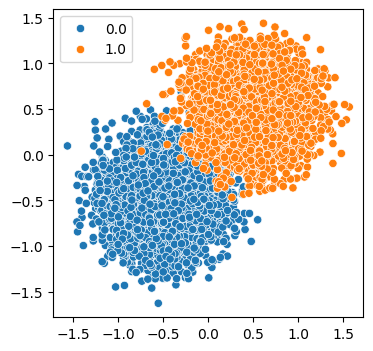

In [2]:
if DS_NAME == "swiss":
    def make_swiss_dataset(num_samples):
        X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
        X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
        X0 = X0[:, [0, 2]]
        X1 = X1[:, [0, 2]]
        X1 = -X1
        X, y = shuffle(
            np.concatenate([X0, X1], axis=0),
            np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
            random_state=0)
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    
        return X.astype(np.float32), y

    X, Y = make_swiss_dataset(2000)
elif DS_NAME == "gaussians":
    factor, sigma = 0.5, 0.3
    mu1, sigma1 = factor * np.array([-1, -1]), sigma
    mu2, sigma2 = factor * np.array([1, 1]), sigma
    ds_size = 10_000
    
    X1 = np.random.randn(ds_size//2, len(mu1)) * sigma1 + mu1
    Y1 = np.ones(len(X1)) * 0.
    X2 = np.random.randn(ds_size//2, len(mu2)) * sigma2 + mu2
    Y2 = np.ones(len(X2)) * 1.
    
    X = np.concatenate([X1, X2]).astype(np.float32)
    Y = np.concatenate([Y1, Y2])

MEAN, STD = np.mean(X, axis=0), np.std(X, axis=0)

plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y)
plt.show()

## Construct Loader

In [3]:
class LabeledDataset(Dataset):
    def __init__(self, X, Y):
        self.X = (X - MEAN[None]) / STD[None]
        self.Y = Y.astype(np.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [4]:
BATCH_SIZE = 256
train_loader = DataLoader(
    LabeledDataset(X=X, Y=Y),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## Unconditional

In [47]:
%load_ext autoreload
%autoreload 2
    
from pfgmpp import PFGMPP
from models import BaseField

model = BaseField(dim=2, hidden_dim=64, n_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
power = 20

pfgmpp = PFGMPP(
    data_dim=2,
    model=model,
    optimizer=optimizer,
    device=device,
    sigma_min=0.002,
    sigma_max=50.,
    D=2**power,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


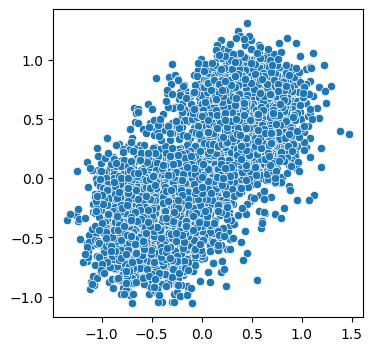

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 478.28it/s, loss=0.585]


In [48]:
n_epochs = 10
sample_every = 10_000
n_gens = 5000

for _ in range(n_epochs):
    clear_output()
    gens = pfgmpp.sample(sample_size=n_gens, num_steps=32) * STD[None] + MEAN[None]
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1])
    plt.xlabel(""); plt.ylabel("")
    plt.show()

    pfgmpp.train(train_loader=train_loader, n_iters=sample_every, log_every=5_000)

In [50]:
# pfgmpp.save_model(os.path.join(UNCONDITIONAL_DIR, f"{int(power)}.pt"))

## Class-conditional

In [52]:
%load_ext autoreload
%autoreload 2
    
from pfgmpp import PFGMPP
from models import BaseField

N_CLASSES = 2

model = BaseField(dim=2, hidden_dim=64, n_layers=3, n_classes=N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
power = 20

pfgmpp = PFGMPP(
    data_dim=2,
    model=model,
    optimizer=optimizer,
    device=device,
    sigma_min=0.002,
    sigma_max=50.,
    D=2**power,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


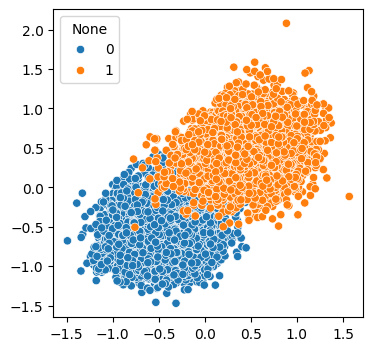

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.45it/s, loss=0.316]


In [53]:
n_epochs = 10
sample_every = 10_000
n_gens = 10_000
label = torch.concatenate([
    torch.zeros(n_gens//2), torch.ones(n_gens//2),
]).to(device).to(torch.long)

for _ in range(n_epochs):
    clear_output()
    gens = pfgmpp.sample(sample_size=n_gens, num_steps=32, label=label) * STD[None] + MEAN[None]
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=label)
    plt.xlabel(""); plt.ylabel("")
    plt.show()

    pfgmpp.train(train_loader=train_loader, n_iters=sample_every, log_every=5_000)

In [54]:
# pfgmpp.save_model(os.path.join(CONDITIONAL_DIR, f"{int(power)}.pt"))

## Classifier Guided

In [5]:
%load_ext autoreload
%autoreload 2
    
from pfgmpp import PFGMPPGuided
from models import BaseField
from nn.networks import TimeConditionedMLP

N_CLASSES = 2

model = BaseField(dim=2, hidden_dim=64, n_layers=3).to(device)
# model = BaseField(dim=2, hidden_dim=64, n_layers=3, n_classes=N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
cls = TimeConditionedMLP(dim=2, hidden_dim=64, n_layers=3, out_dim=N_CLASSES).to(device)
cls_optimizer = torch.optim.Adam(cls.parameters(), lr=3e-4)
power = 20

pfgmpp = PFGMPPGuided(
    data_dim=2,
    model=model,
    optimizer=optimizer,
    cls=cls,
    cls_optimizer=cls_optimizer,
    device=device,
    sigma_min=0.002,
    sigma_max=50.,
    D=2**power,
)

In [10]:
pfgmpp.train_classifier(train_loader, n_iters=50_000, log_every=5_000)

100%|████████████████████████| 50000/50000 [02:25<00:00, 344.61it/s, loss=0.688, score=0.524, sigma_max_loss=0.693, sigma_max_score=0.509, sigma_min_loss=0.0331, sigma_min_score=0.989]


In [11]:
# pfgmpp.save_classifier(os.path.join(CLASSIFIER_DIR, f"{int(power)}.pt"))

In [6]:
pfgmpp.load_model(os.path.join(UNCONDITIONAL_DIR, f"{int(power)}.pt"))
pfgmpp.load_classifier(os.path.join(CLASSIFIER_DIR, f"{int(power)}.pt"))

In [7]:
# sampling parameters
n_gens = 20_000
# label = torch.zeros(n_gens).to(device).to(torch.long)
label = torch.concatenate([
    torch.zeros(n_gens//2), torch.ones(n_gens//2),
]).to(device).to(torch.long)

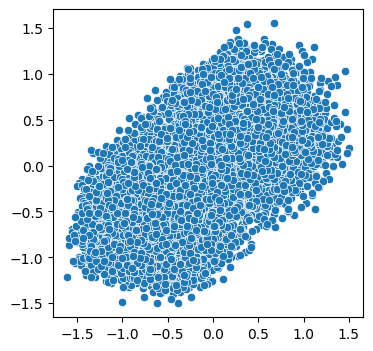

In [8]:
# check unconditional
gens = pfgmpp.sample_unconditional(sample_size=n_gens, rho=7, num_steps=32, label=label) * STD[None] + MEAN[None]
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1])
plt.xlabel(""); plt.ylabel("")
plt.show()

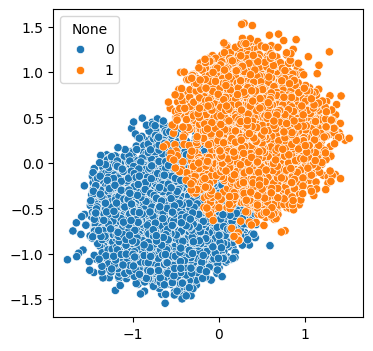

In [9]:
# with guidance
gens = pfgmpp.sample(sample_size=n_gens, rho=7, num_steps=32, label=label, guidance_scale=1.) * STD[None] + MEAN[None]
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=label)
plt.xlabel(""); plt.ylabel("")
plt.show()

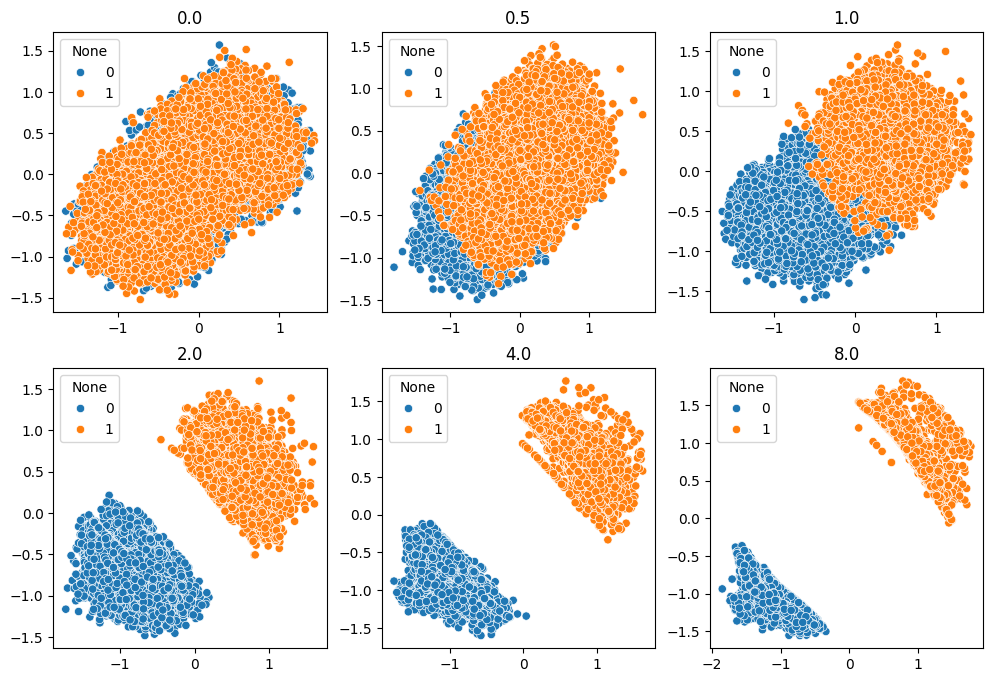

In [10]:
scales = [0.] + [float(2**p) for p in [-1, 0, 1., 2, 3]]
nplots = len(scales)
ncols, nrows = 3, nplots//3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))

for idx, scale in enumerate(scales):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]
    
    gens = pfgmpp.sample(sample_size=n_gens, rho=7, num_steps=32, label=label, guidance_scale=scale) * STD[None] + MEAN[None]
    
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=label, ax=ax)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_title(f"{np.round(scale, 1)}")